## K-means clustering

It is important to note that K-means clustering problem is not solved by ADDM. 

The goal is to show a bipartite graph structure in admm4j can be exploited beyond ADMM algorithm.

### Steps

1. Devise a computation graph representing the problem as a bipartite graph
2. Implement nodes as Java classes extending org.admm4j.core.Node
3. Create the JSON input defining the graph
4. Execute admm4j
5. Import and analyze results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

### Generate data for clustering

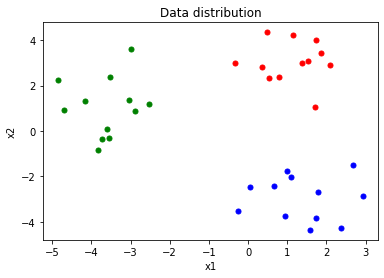

In [2]:
np.random.seed(1200)

# init centers
c1 = np.array([1, 3])
c2 = np.array([-3, 1])
c3 = np.array([1, -3])

# sample data
d1 = c1 + np.random.normal(0, 1, (12,2))
d2 = c2 + np.random.normal(0, 1, (12,2))
d3 = c3 + np.random.normal(0, 1, (12,2))

data = np.concatenate((d1, d2, d3), axis=0)

# plot data
plt.plot(data[0:12,0], data[0:12,1], 'r.', markersize=10)
plt.plot(data[12:24,0], data[12:24,1], 'g.', markersize=10)
plt.plot(data[24:36,0], data[24:36,1], 'b.', markersize=10)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data distribution")
plt.show()

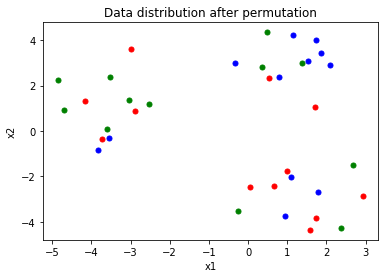

In [3]:
# permute data points
idx = np.random.permutation(data.shape[0])
data = data[idx,:]

# plot data
plt.plot(data[0:12,0], data[0:12,1], 'r.', markersize=10)
plt.plot(data[12:24,0], data[12:24,1], 'g.', markersize=10)
plt.plot(data[24:36,0], data[24:36,1], 'b.', markersize=10)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data distribution after permutation")
plt.show()

### Step 1. Devise a computation graph representing the problem as a bipartite graph

The data is distributed across worker nodes.\
Workers update cluster centers using local data.\
Master averages the results collected from workers.
#### The calculation of primal residual in master differs from ADMM.

<img src="images/master-workers1.png" width="600" height="600" style="float: center"/>

### Step 2. Implement nodes as Java classes extending org.admm4j.core.Node

The following classes are implemented
1. org.admm4j.demo.ml.cluster.KMeansWorker.java 
2. org.admm4j.demo.ml.cluster.KMeansMaster.java

### Step 3. Create the JSON input defining the graph

The JSON input has a well-defined structure allowing to define an arbitrary bipartite graph.

Here the JSON input is created in python.

In [4]:
# here we cluster the data into 3 clusters with data being distributed across 4 workers having 9 points in each node
num_workers = 4
num_clusters = 3
points_per_node = 9

# init nodesI.
nodesI = []
for i in range(0, num_workers):
    # define node
    node = {}
    node['name'] = 'worker{}'.format(i)
    node['class'] = 'org.admm4j.demo.ml.cluster.KMeansWorker'
    node['neighbors'] = ['master']
    node['input'] = {'k': num_clusters, 'data': data[i*points_per_node:(i+1)*points_per_node:,:].tolist()}
    # add to the list of nodesI
    nodesI.append(node)

# init nodesII
nodesII = []
node = {}
node['name'] = 'master'
node['class'] = 'org.admm4j.demo.ml.cluster.KMeansMaster'
node['neighbors'] = None
node['input'] = {'k': num_clusters}
nodesII.append(node)

# init whole json model
model = {'nodesI': nodesI, 'nodesII': nodesII}

#### Show JSON model

In [5]:
print(json.dumps(model))

{"nodesI": [{"name": "worker0", "class": "org.admm4j.demo.ml.cluster.KMeansWorker", "neighbors": ["master"], "input": {"k": 3, "data": [[0.5443009226568495, 2.3181259541319132], [1.585754621823286, -4.359023882384643], [0.04885666192932625, -2.4591580172578227], [1.7044854166704497, 1.0413609155774386], [-4.162579950537012, 1.3246762364182372], [1.7438665364691088, -3.8543404909835592], [0.6526230986614925, -2.430230344423357], [1.006626776293171, -1.7699319397795772], [-2.985428769928258, 3.6063399893309667]]}}, {"name": "worker1", "class": "org.admm4j.demo.ml.cluster.KMeansWorker", "neighbors": ["master"], "input": {"k": 3, "data": [[-3.740360905594781, -0.3329546731008901], [-2.8899256563343507, 0.8729959179269986], [2.922239106915986, -2.8579672493143233], [-2.537854622628764, 1.2045533775390918], [0.4956575886051984, 4.349763512220156], [0.36280557287058146, 2.805236608624553], [2.364971863319541, -4.284961114823476], [-3.6003230886807542, 0.10730698115363735], [1.3871629508638823

#### Save JSON input file

In [6]:
filename = 'kmeans_input.json'
fout = open(filename, 'w')
json.dump(model, fout, indent=4)
fout.close()

### Step 4. Execute admm4j

Following parameters are provided:
1. -input 
2. -output 
3. -nvar

#### Note: -nvar is provided in command line (-rho is not defined because ADMM algorithm is not used in k-means)

In [7]:
!java -jar admm4j-demo/target/admm4j-demo-1.0-jar-with-dependencies.jar\
           -input kmeans_input.json\
           -output kmeans_output.json\
           -nvar 6

### Step 5. Import and analyze results

In [8]:
fin = open('kmeans_output.json', 'r')
res = json.loads(fin.read())
fin.close()

#### Visulalize cluster centers

c0 [-3.618605802874198, 1.019850995490548]
c1 [1.5354663669029083, -2.9678476675760725]
c2 [1.110371404708365, 2.9086414685419273]


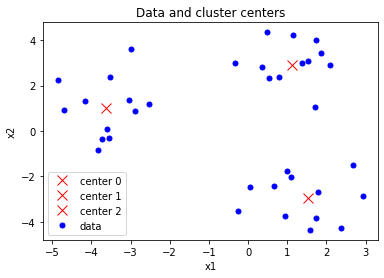

In [9]:
for key in res.get('nodesII')[0].get('internal').keys():
    c = res.get('nodesII')[0].get('internal').get(key)
    print(key, c)
    plt.plot(c[0], c[1], 'rx', markersize=10)
    
plt.plot(data[:,0], data[:,1], 'b.', markersize=10)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data and cluster centers")
plt.legend(['center 0', 'center 1', 'center 2', 'data'])
plt.show()

Reasonable cluster centers were found.

Data proints closest to a particular center form a cluster.

For practical data sets, initial cluster centers can be provided in the input.

### Comparing with KMeans in scikit-learn

c0 [1.1090571271141376, 3.0440830279235875]
c1 [1.381819038115245, -2.9568749275989497]
c2 [-3.6157968125533886, 1.0448310084914836]


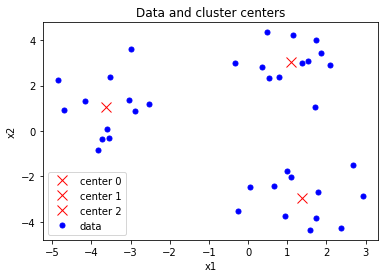

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)

for k in range(3):
    print('c{}'.format(k), kmeans.cluster_centers_[k,:].tolist())
    plt.plot(kmeans.cluster_centers_[k,0], kmeans.cluster_centers_[k,1], 'rx', markersize=10)
    
plt.plot(data[:,0], data[:,1], 'b.', markersize=10)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Data and cluster centers")
plt.legend(['center 0', 'center 1', 'center 2', 'data'])
plt.show()

Similar results are obtained.